# Golf Ontario Men's Mid-Amateur Qualifying Event Analysis


<h2>Load Libraries</h2>

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import patsy
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve

sns.set_style('darkgrid')

In [2]:
# Set Seaborn style upfront
sns.set_style('darkgrid')

<h2>Load Datasets</h2>

For my analysis, I have included events from the 2023-2025 seasons, totalling 25 qualifiers and over 1,400 scores.

In [3]:
events = pd.read_excel('/Users/adrianmazzarolo/Library/CloudStorage/OneDrive-Personal/Golf Ontario Qualifying Analysis.xlsx',
                       sheet_name='Events').set_index('Event ID').sort_index()
events

,Qualifier Course,Date,Mean Temperature (Celcius),Mean Wind Gusts (km/h),Rain Sum (mm),Qualifying Spots,Field Size,Rating,Slope,Latitude,Longitude
Event ID,,,,,,,,,,,
1,Sarnia G&CC,2025-04-29,17.9,51.7,0.9,10,45,71.6,127,42.991456,-82.395360
2,Cobble Beach GL,2025-05-12,13.4,23.5,0.0,13,63,70.9,126,44.691215,-80.922446
3,Essex G&CC,2025-05-12,16.2,17.5,0.4,12,71,71.7,137,42.219854,-83.080018
4,Toronto GC,2025-05-12,14.7,16.3,0.0,15,78,73.7,141,43.590292,-79.558779
5,Kawartha GC,2025-05-20,9.0,21.9,0.0,15,78,71.5,137,44.286951,-78.357116
6,Mystic GC,2025-05-26,13.1,14.1,0.1,14,72,72.4,135,43.210648,-80.066711
7,Craigowan GC,2025-05-28,12.0,30.1,6.6,14,71,72.1,130,43.168925,-80.780057
8,Idylwylde G&CC,2025-06-07,17.7,24.2,0.0,5,28,71.8,135,46.464762,-80.986497
9,Glendale GC,2024-05-09,10.9,21.3,0.0,13,70,70.5,128,43.210142,-79.798546


In [4]:
# Create some new column for qualifying rate. Field Size includes WDs and DQs, otherwise qualifying rate is out of whack. 
## Number of qualifiers is determined through a spot formula that takes into account the active field numbers at the time of registration 
## closing at each qualifying site in relation to the total number of registered participant’s attempting to qualify in the championship. 
## The goal of the spot formula is to give as equitable as possible the number of qualifying spots to be competed for at each site based on 
## the field of participants at each location. The formula takes the number of participants at each specific qualifier and divides that 
## number by the total number of players attempting to qualify for the championship. The total number of qualifying spots made available 
## for the championship is determined after Golf Ontario delegates its exemption spots.


# So basically, number of qualifiers for a site is determined after registration has closed. Considers field size relative to total number
# trying to qualify for championship (i.e., larger fields = larger proportion of total trying to qualify = more qualifying spots).

## Info on qualifying spots: https://gao.bluegolf.com/bluegolfw/gao/mo/AQ_Spots_Explained.htm
events['Qualifying Rate (%)'] = (events['Qualifying Spots'] / events['Field Size'])*100  # multiplying by 100 for scale

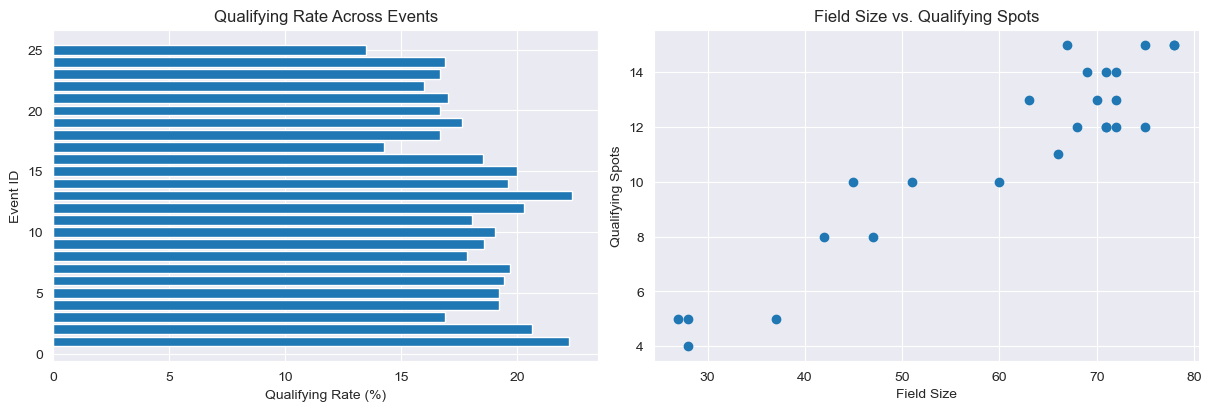

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (12,4), layout='constrained')

axs[0].barh(data=events, y=events.index, width='Qualifying Rate (%)')
axs[0].set_title('Qualifying Rate Across Events')
axs[0].set_ylabel('Event ID')
axs[0].set_xlabel('Qualifying Rate (%)')

axs[1].scatter(data=events, x='Field Size', y='Qualifying Spots')
axs[1].set_title('Field Size vs. Qualifying Spots')
axs[1].set_xlabel('Field Size')
axs[1].set_ylabel('Qualifying Spots');

## Insight: Seems like field size and qualifying rate seem to be fairly well aligned throughout the events. Also seems like there has been an increase in the qualifying rate % since 2023. Less exemptions = More qualifying spots?

In terms of initial thoughts on field difficulty:
- Seems like its gone from a median of ~16-17% in 2023 to ~19% in 2024-2025. 
- Seems like most events have > 65 players in it, so tend to deal with similar field sizes 

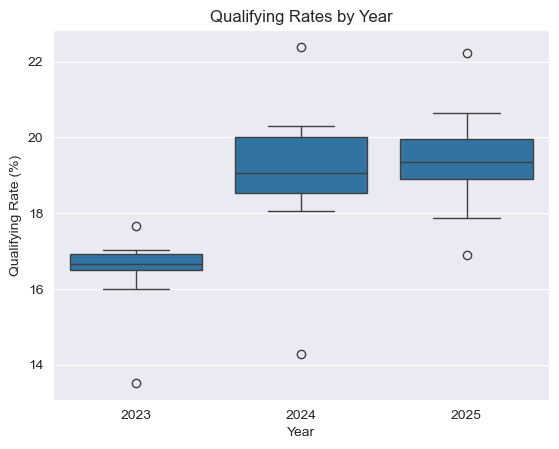

In [6]:
qrs_annual = pd.concat([events['Qualifier Course'],events['Date'].dt.year, events['Qualifying Rate (%)']], axis=1)
ax = sns.boxplot(data=qrs_annual, x='Date', y='Qualifying Rate (%)')
ax.set_title('Qualifying Rates by Year')
ax.set_ylabel('Qualifying Rate (%)')
ax.set_xlabel('Year');

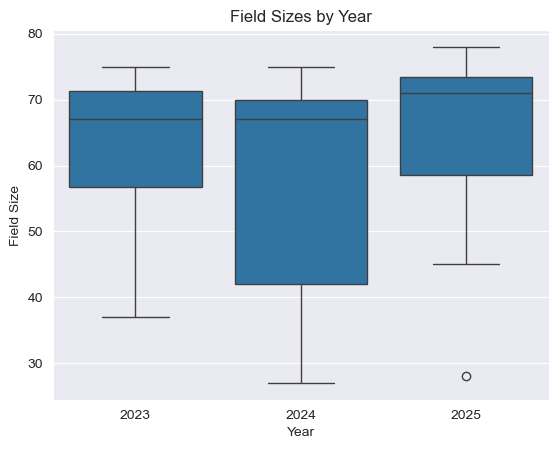

In [7]:
ax = sns.boxplot(x=events['Date'].dt.year, y=events['Field Size'])
ax.set_title('Field Sizes by Year')
ax.set_ylabel('Field Size')
ax.set_xlabel('Year');

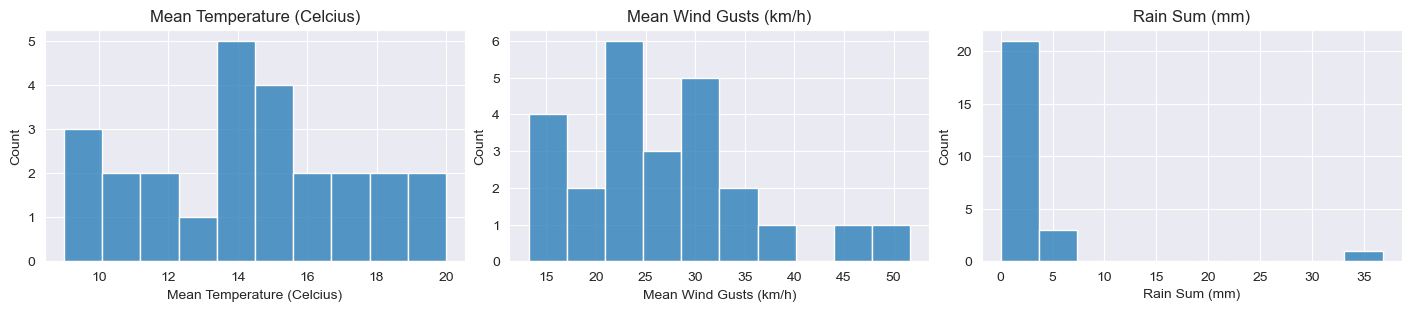

In [8]:
# Weather data --> Sourced from https://open-meteo.com/en/docs/historical-weather-api
weather_cols = ['Mean Temperature (Celcius)', 'Mean Wind Gusts (km/h)', 'Rain Sum (mm)']
fig, axs = plt.subplots(1, 3, figsize=(14,3), layout='constrained')

for ax, col in enumerate(weather_cols):
    sns.histplot(data=events, x=col, bins=10, ax=axs[ax])
    axs[ax].set_title(f'{col}')

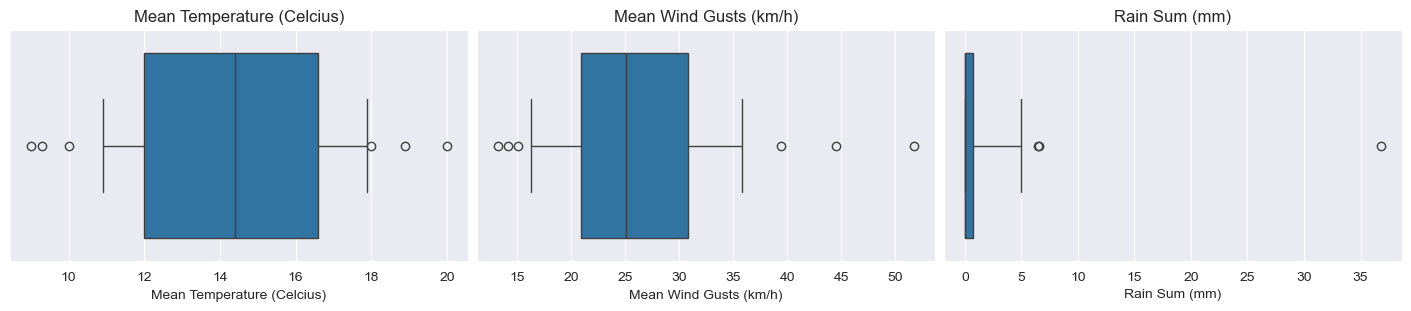

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(14,3), layout='constrained')

for ax, col in enumerate(weather_cols):
    sns.boxplot(data=events, x=col, ax=axs[ax], whis=[10,90])
    axs[ax].set_title(f'{col}')

If point is above / below its in 10th or 90th percentile, so I would consider that an outlier weather scenario.

So most events share a similar temperature profile, between 13-17˚C. Typical wind speeds were between 20-30 km/h. Most events did not have much rain.

Outlier IDs include:
- Cold Temperature: 5, 21, and 24 (<=10˚C)
- High Winds: 1, 7, 10, 11, 12, 13, 18, 20, 23 (>=30km/h)
- Large Rainfall: 7, 13, 25 (> 5mm)

Weather levels:
- If none of the above conditions --> Adverse Weather = Low
- If just one --> Medium
- If 2+ --> High

In [10]:
events['Adverse Weather Events'] = pd.concat([events['Mean Temperature (Celcius)']<=10, events['Mean Wind Gusts (km/h)'] >= 30, events['Rain Sum (mm)'] > 5], axis=1).sum(axis=1)

In [11]:
weather_risk = {0: 'Low', 1: 'Medium', 2: 'High'}
events['Weather Risk'] = events['Adverse Weather Events'].map(weather_risk)

In [12]:
# Now we can remove data we don't need since we've classified them accordingly.
events = events.drop(['Mean Temperature (Celcius)', 'Mean Wind Gusts (km/h)', 'Rain Sum (mm)', 'Adverse Weather Events'], axis=1)
events.head(10)

,Qualifier Course,Date,Qualifying Spots,Field Size,Rating,Slope,Latitude,Longitude,Qualifying Rate (%),Weather Risk
Event ID,,,,,,,,,,
1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.395360,22.222222,Medium
2,Cobble Beach GL,2025-05-12,13,63,70.9,126,44.691215,-80.922446,20.634921,Low
3,Essex G&CC,2025-05-12,12,71,71.7,137,42.219854,-83.080018,16.901408,Low
4,Toronto GC,2025-05-12,15,78,73.7,141,43.590292,-79.558779,19.230769,Low
5,Kawartha GC,2025-05-20,15,78,71.5,137,44.286951,-78.357116,19.230769,Medium
6,Mystic GC,2025-05-26,14,72,72.4,135,43.210648,-80.066711,19.444444,Low
7,Craigowan GC,2025-05-28,14,71,72.1,130,43.168925,-80.780057,19.718310,High
8,Idylwylde G&CC,2025-06-07,5,28,71.8,135,46.464762,-80.986497,17.857143,Low
9,Glendale GC,2024-05-09,13,70,70.5,128,43.210142,-79.798546,18.571429,Low


In [13]:
events['Weather Risk'].value_counts()

Weather Risk
Low       12
Medium    11
High       2
Name: count, dtype: int64

<h2>Two events were "High" weather risk. Mystic GC in 2024 due to its high winds and massive rainfall, and Craigowan GC in 2025 due to its high winds and moderate rain.</h2>

<h2>Exploratory Data Analysis</h2>

In [14]:
m = folium.Map(location=[44.5,-79.5],zoom_start=7)

for row in range(events.shape[0]):
    coords = (events['Latitude'].iloc[row], events['Longitude'].iloc[row])
    folium.Marker(coords, popup=events['Qualifier Course'].iloc[row]).add_to(m)
m

I will classify regions in to the four following groups based on location:
- West (Woodstock and further west) -- Latitude below 43.17; Longitude below -80.77
- North (Barrie and further north / northwest) -- Latitude above 44.30; Longitude below -79.77
- East (Peterborough and further east) -- Latitude above 43.75; Longitude above -79.34
- Central (GTA) -- All others

In [15]:
events['Region'] = pd.Series()

def assign_region(row):
    if row['Latitude'] < 43.17 and row['Longitude'] < -80.77:
        return 'West'
    elif row['Latitude'] > 44.30 and row['Longitude'] < -79.77:
        return 'North'
    elif row['Latitude'] > 43.75 and row['Longitude'] > -79.34:
        return 'East'
    else:
        return 'Central'

events['Region'] = events.apply(assign_region, axis=1)

In [16]:
events.head(10)

,Qualifier Course,Date,Qualifying Spots,Field Size,Rating,Slope,Latitude,Longitude,Qualifying Rate (%),Weather Risk,Region
Event ID,,,,,,,,,,,
1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.395360,22.222222,Medium,West
2,Cobble Beach GL,2025-05-12,13,63,70.9,126,44.691215,-80.922446,20.634921,Low,North
3,Essex G&CC,2025-05-12,12,71,71.7,137,42.219854,-83.080018,16.901408,Low,West
4,Toronto GC,2025-05-12,15,78,73.7,141,43.590292,-79.558779,19.230769,Low,Central
5,Kawartha GC,2025-05-20,15,78,71.5,137,44.286951,-78.357116,19.230769,Medium,East
6,Mystic GC,2025-05-26,14,72,72.4,135,43.210648,-80.066711,19.444444,Low,Central
7,Craigowan GC,2025-05-28,14,71,72.1,130,43.168925,-80.780057,19.718310,High,West
8,Idylwylde G&CC,2025-06-07,5,28,71.8,135,46.464762,-80.986497,17.857143,Low,North
9,Glendale GC,2024-05-09,13,70,70.5,128,43.210142,-79.798546,18.571429,Low,Central


In [17]:
m = folium.Map(location=[44.5,-79.5],zoom_start=7)

color_map = {
    'West': 'purple',
    'East': 'red',
    'North': 'green',
    'Central': 'darkblue'
}

for index, row in events.iterrows():

    popup_content = f'Course: {row['Qualifier Course']}<br><br>Region: {row['Region']}'
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_content,
        icon=folium.Icon(color=color_map[row['Region']])
    ).add_to(m)
m

<h2>Scores Data</h2>

In [18]:
scores = pd.read_excel('/Users/adrianmazzarolo/Library/CloudStorage/OneDrive-Personal/Golf Ontario Qualifying Analysis.xlsx',
                       sheet_name='Scores')
scores.head(20)

## Question on retrogression. Explain.

,Pos.,To Par,Total,Outcome,Event ID
0,1,-1,71,Qualified,1
1,2,0,72,Qualified,1
2,3,1,73,Qualified,1
3,3,1,73,Qualified,1
4,5,3,75,Qualified,1
5,5,3,75,Qualified,1
6,7,4,76,Qualified,1
7,7,4,76,Qualified,1
8,7,4,76,Qualified,1
9,10,5,77,Qualified,1


In [19]:
scores = scores.merge(right=events, how='left', on='Event ID')
scores.head(10)

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Qualifying Spots,Field Size,Rating,Slope,Latitude,Longitude,Qualifying Rate (%),Weather Risk,Region
0,1,-1,71,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
1,2,0,72,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
2,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
3,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
4,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
5,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
6,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
7,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
8,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West
9,10,5,77,Qualified,1,Sarnia G&CC,2025-04-29,10,45,71.6,127,42.991456,-82.39536,22.222222,Medium,West


In [20]:
# Create a new column for score relative to rating and drop latitude and longitude as they were only being used to determine region.
scores['To Rating'] = scores['Total'] - scores['Rating']
scores = scores.drop(['Latitude', 'Longitude'], axis=1)

# Also drop qualifying spots and field size as they are now considered more succinctly in qualifying_rate
scores = scores.drop(['Qualifying Spots', 'Field Size'], axis=1)
scores.head(10)

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Rating,Slope,Qualifying Rate (%),Weather Risk,Region,To Rating
0,1,-1,71,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,-0.6
1,2,0,72,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,0.4
2,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4
3,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4
4,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4
5,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4
6,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4
7,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4
8,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4
9,10,5,77,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,5.4


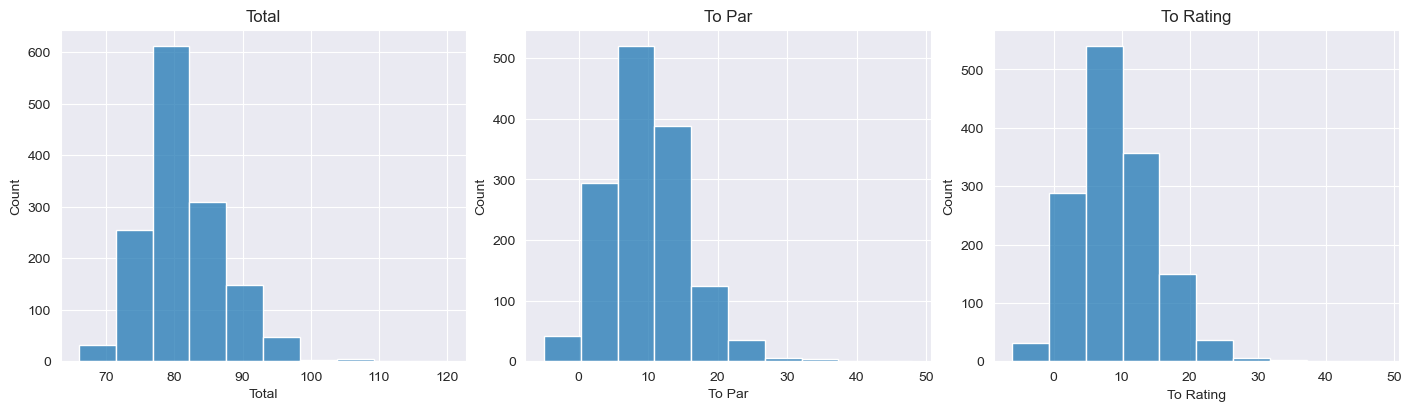

In [21]:
cols = ['Total', 'To Par', 'To Rating']

fig, axs = plt.subplots(1, 3, figsize=(14, 4), layout='constrained')

for ax, col in enumerate(cols):
    sns.histplot(scores, x=col, bins=10, ax=axs[ax])
    axs[ax].set_title(col);

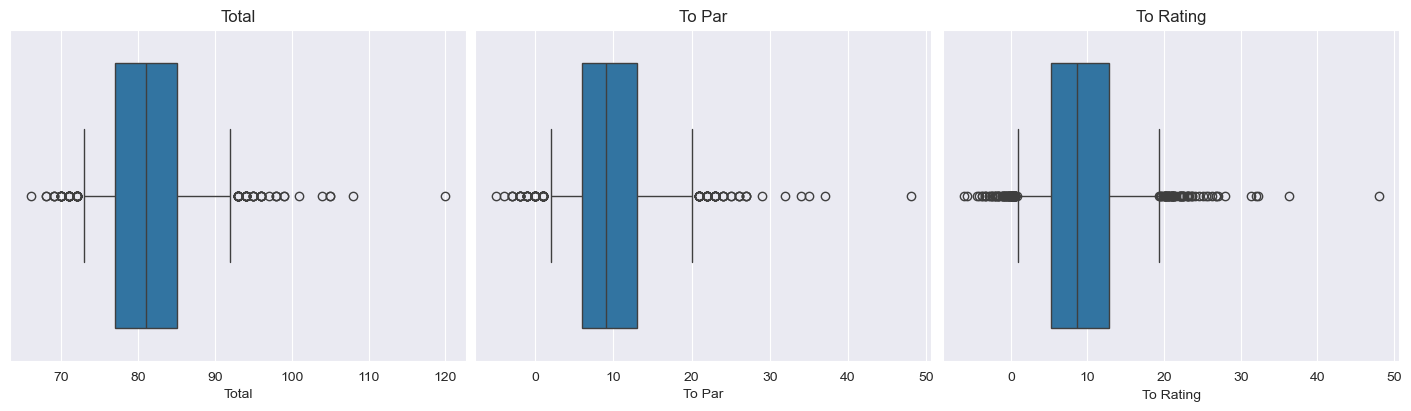

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), layout='constrained')

for ax, col in enumerate(cols):
    sns.boxplot(scores[col], ax=axs[ax], orient='h', whis=[5,95])
    axs[ax].set_title(col);

<h2>Median score is about 81. Relative to par and course rating, about +9.</h2>
If you want to be in the top 5%, you need to shoot ~73, which is equivalent to +2 relative to par and ~+1.0 relative to course rating. Understanding the median qualifying rate was 18.5%, that means a "quick and dirty" analysis would say you need to be in the top 18.5% of scores to qualify, on average. This equals to 76, +5 (vs. Par), or +4 (vs. Rating); with that being said, we know that not all 76's are equal, as shown in the charts below. Some players qualified with scores multiple shots above this, including 21 scores of 78 or above. Interestingly, 18 of these 21 scores came from two qualifiers; Mystic GC and Black Bear Ridge, both of which during the 2024 season. While Mystic had the worst weather combination of any (extreme wind and rain; speaking from personal experience!), it is unclear what made qualifying scores at Black Bear Ridge noticeably higher than others. 

When we stratify based on the outcome of a score, rather than taking a crude expected qualifying rate, we see that the true median qualifying score was actually 74, +3 (vs. Par), or +2 (vs. Rating). 

These sort of nuances are what highlight the need for a more in-depth approach and where we are going to use predictive modelling to get a better pulse on how other factors can effect the "competitiveness" of a score.

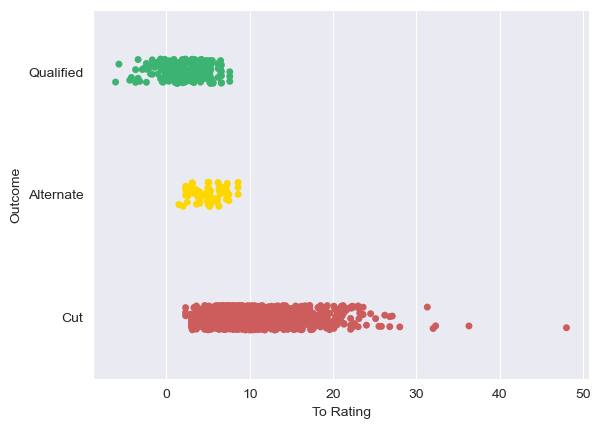

In [23]:
palette = {'Qualified': 'mediumseagreen', 'Alternate': 'gold', 'Cut':'indianred'}
sns.stripplot(scores, y='Outcome', x='To Rating', hue='Outcome', palette=palette, orient='h');

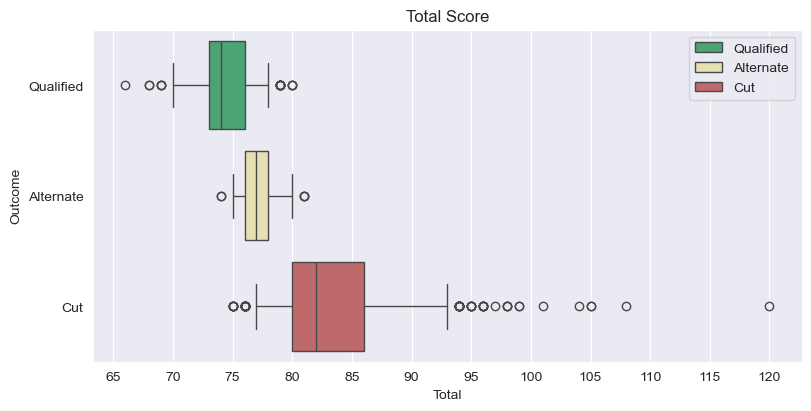

In [24]:
palette = {'Qualified': 'mediumseagreen', 'Alternate': 'palegoldenrod', 'Cut':'indianred'}
ax = plt.subplots(figsize=(8, 4),layout='constrained')[1]

new_xticks = np.arange(65,125,step=5)
sns.boxplot(scores, x='Total', y='Outcome', hue='Outcome', orient='h', palette=palette, whis=[5,95])
ax.set_title('Total Score')
ax.set_xticks(new_xticks)
ax.legend(['Qualified', 'Alternate', 'Cut']);

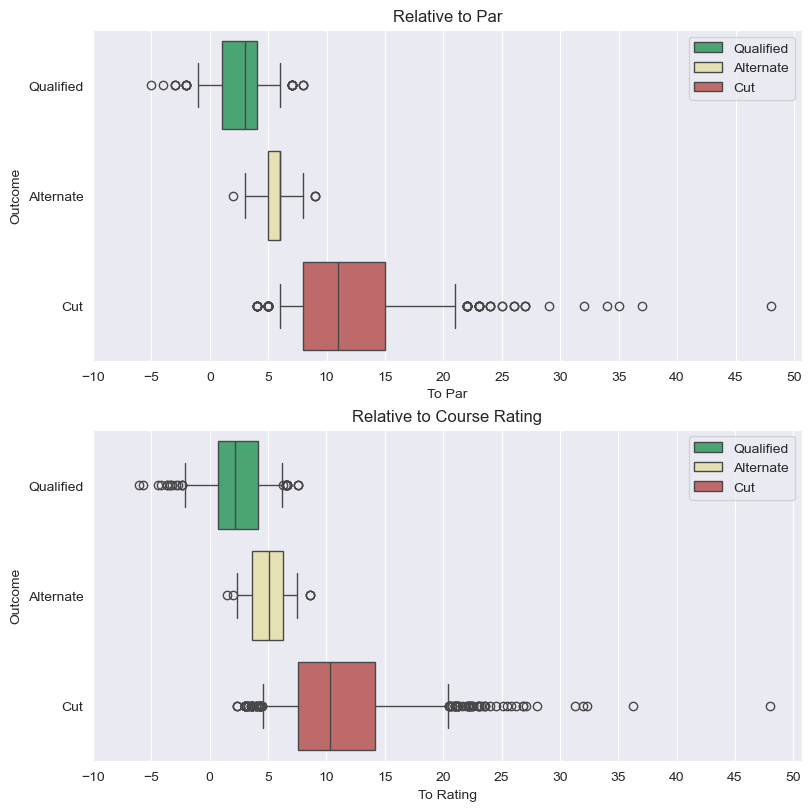

In [25]:
# Relative to Par
fig, axs = plt.subplots(2, 1, figsize=(8, 8),layout='constrained')

new_xticks = np.arange(-10, 51, step=5)

sns.boxplot(scores, x='To Par', y='Outcome', hue='Outcome', orient='h', ax=axs[0], palette=palette, whis=[5,95])
axs[0].set_title('Relative to Par')
axs[0].set_xticks(new_xticks)
axs[0].legend(['Qualified', 'Alternate', 'Cut'])

sns.boxplot(scores, x='To Rating', y='Outcome', hue='Outcome', orient='h', ax=axs[1], palette=palette, whis=[5,95])
axs[1].set_title('Relative to Course Rating')
axs[1].set_xticks(new_xticks)
axs[1].legend(['Qualified', 'Alternate', 'Cut']);

In [26]:
scores[(scores['Outcome']=='Qualified') & (scores['Total']>=78)]

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Rating,Slope,Qualifying Rate (%),Weather Risk,Region,To Rating
726,5,6,78,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,5.6
727,5,6,78,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,5.6
728,7,7,79,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,6.6
729,7,7,79,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,6.6
730,7,7,79,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,6.6
731,7,7,79,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,6.6
732,7,7,79,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,6.6
733,12,8,80,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,7.6
734,12,8,80,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,7.6
735,12,8,80,Qualified,13,Mystic GC,2024-05-27,72.4,135,22.388060,High,Central,7.6


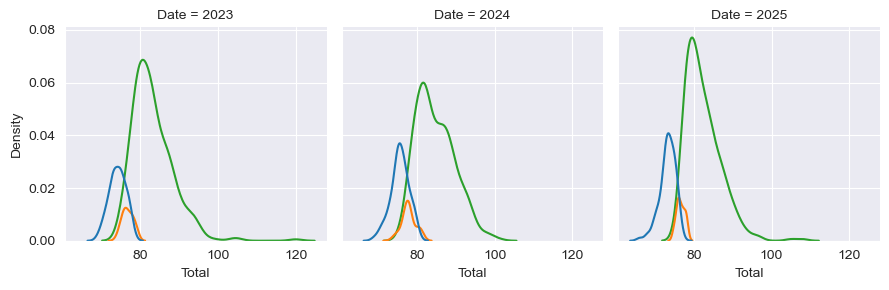

In [27]:
years = scores['Date'].dt.year
df = pd.concat([years, scores['Total'], scores['To Par'], scores['To Rating'], scores['Outcome']], axis=1)

g = sns.FacetGrid(df, col='Date')
g.map_dataframe(sns.kdeplot, x='Total', hue='Outcome');

In [28]:
for col in cols:
    print(f'{df.groupby(['Date', 'Outcome'])[col].median()}\n\n')

Date  Outcome  
2023  Alternate    77.0
      Cut          82.0
      Qualified    74.0
2024  Alternate    78.0
      Cut          84.0
      Qualified    76.0
2025  Alternate    76.5
      Cut          81.0
      Qualified    73.0
Name: Total, dtype: float64


Date  Outcome  
2023  Alternate     5.0
      Cut          11.0
      Qualified     3.0
2024  Alternate     6.0
      Cut          12.0
      Qualified     4.0
2025  Alternate     5.0
      Cut          10.0
      Qualified     2.0
Name: To Par, dtype: float64


Date  Outcome  
2023  Alternate     4.00
      Cut          10.00
      Qualified     1.60
2024  Alternate     5.95
      Cut          11.80
      Qualified     4.00
2025  Alternate     5.00
      Cut           9.30
      Qualified     1.45
Name: To Rating, dtype: float64




<h2>Scores by Region</h2>
Going into this analysis, I was very interested in how scores would vary based on region. My initial concern was the potential for "venue shopping", where competitors may drive to a site much further and potentially more "remote" from where they live in the hopes of experiencing an "easier" qualifying scenario. I use quotations here as I am working strictly on assumptions rather than fact.

Based on the analysis below, competitive parity seems to be quite strong across regions. For example, relative to par, three of the four regions have the same median qualifying score of +3, with the remaining region (West) at +2. When looking on a more relative basis (course rating), parity falters slightly, with median qualifying scores ranging from +1.4 to +3.3 versus course rating. So while it appears that some regions have stronger fields (based on qualifying requiring a lower relative score), I believe having nearly identical qualifying scores relative to par, a fairly tight band relative to course rating, and a policy that restricts qualifying spots for smaller sites (and thereby reduces "venue shopping" is admirable and gives me confidence in the legitimacy of qualifiers as a selection process.


# For me to be concerned with parity, I would need to see a much more noticable discrepancy. Most people also "play against par" rather than course rating, so I think looking at that being identical across three of the regions, and within a shot of the final region is very impressive. Qualifier spot policy appears to mitigate against "venue shopping" well. 

# What's more, it seems like across every outcome the scores are very close together.

<!-- Additionally, I think Golf Ontario's current qualifying spot policy re: larger fields having greater qualifying spots reduces the ability for the aforementioned "venue shopping". Going to a remote location won't help you as much as it would if there were an equal number of qualifiers across all sites. It appears truly on the player to play a solid round to qualify, rather than choosing an easier course or region. The great equalizer. -->

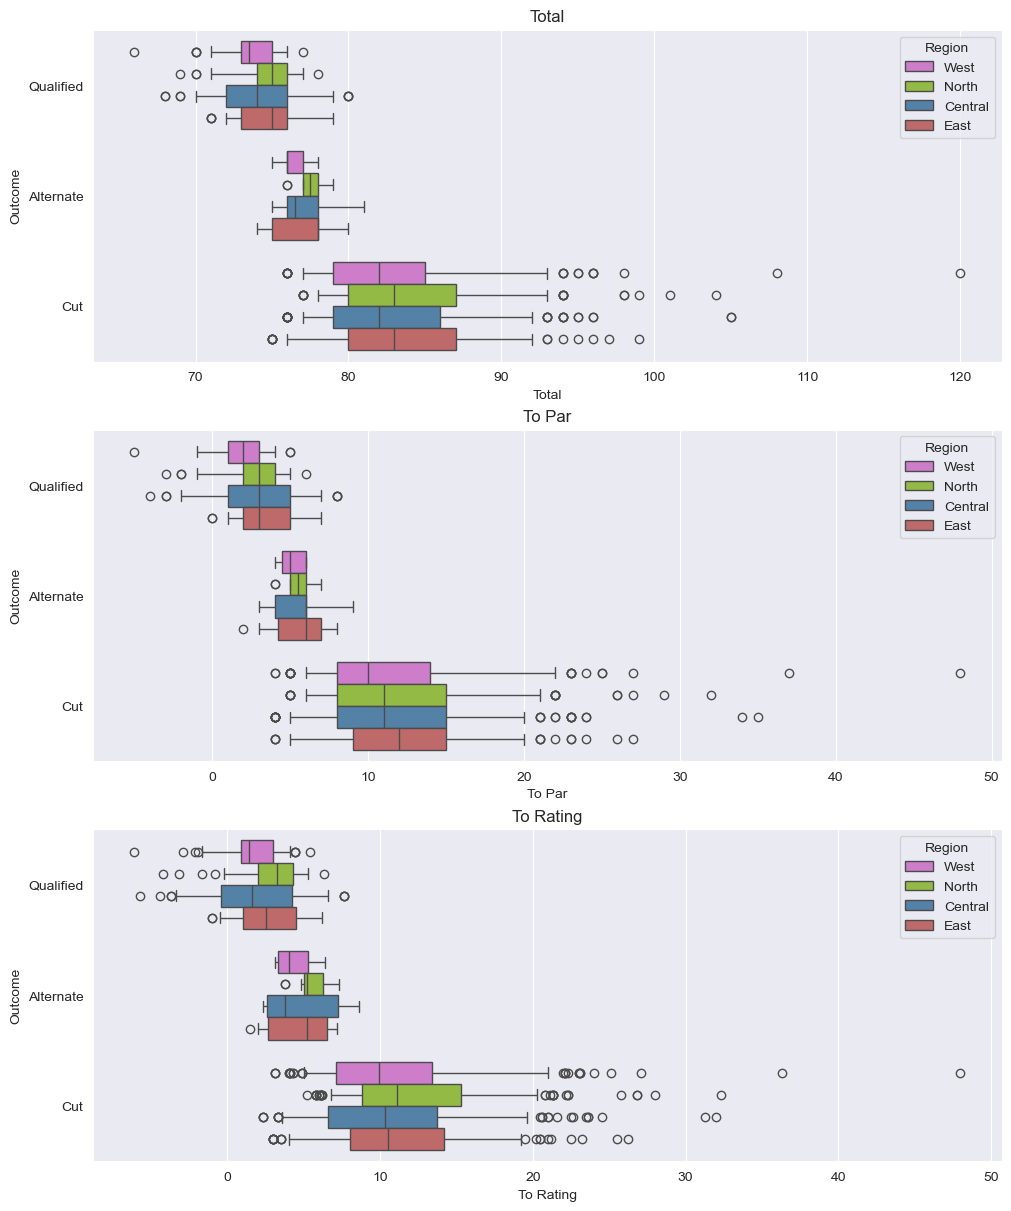

In [29]:
palette = {'West': 'orchid', 'North': 'yellowgreen', 'Central':'steelblue', 'East':'indianred'}

fig, axs = plt.subplots(3, 1, figsize=(10, 12),layout='constrained')

cols = ['Total', 'To Par', 'To Rating']

for ax, col in enumerate(cols):
    sns.boxplot(scores, x=col, y='Outcome', hue='Region', orient='h', whis=[5,95], ax=axs[ax], palette=palette)
    axs[ax].set_title(col);

In [30]:
scores.groupby(['Region','Outcome'])['To Rating'].median()

Region   Outcome  
Central  Alternate     3.80
         Cut          10.30
         Qualified     1.60
East     Alternate     5.20
         Cut          10.50
         Qualified     2.50
North    Alternate     5.20
         Cut          11.10
         Qualified     3.25
West     Alternate     4.00
         Cut           9.90
         Qualified     1.40
Name: To Rating, dtype: float64

In [31]:
events.groupby('Region')['Rating'].median()

# North and West have slightly easier courses

Region
Central    72.40
East       72.50
North      71.75
West       71.85
Name: Rating, dtype: float64

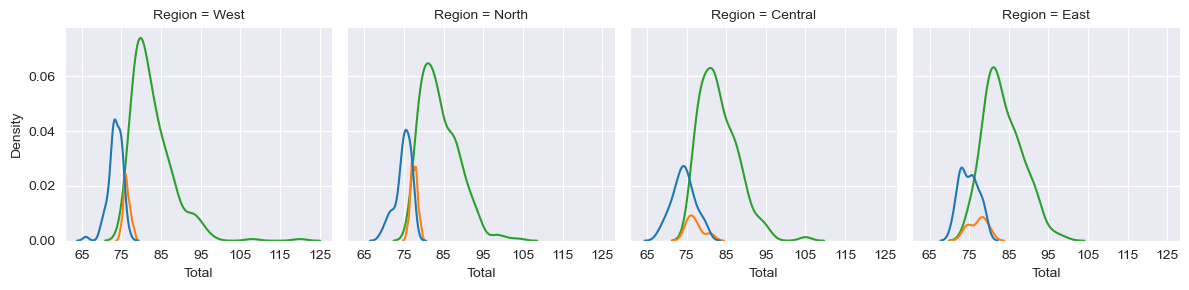

In [32]:
g = sns.FacetGrid(scores, col='Region')
g.map_dataframe(sns.kdeplot, x='Total', hue='Outcome')
g.set(xticks=np.arange(65,126,10));

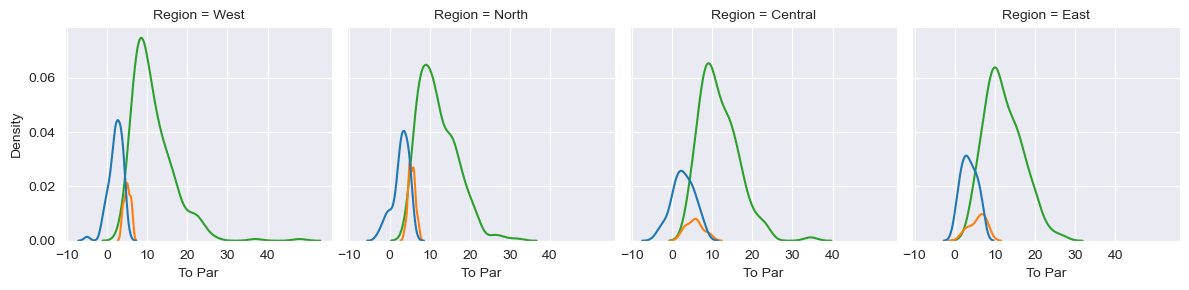

In [33]:
g = sns.FacetGrid(scores, col='Region')
g.map_dataframe(sns.kdeplot, x='To Par', hue='Outcome')
g.set(xticks=np.arange(-10,41,10));

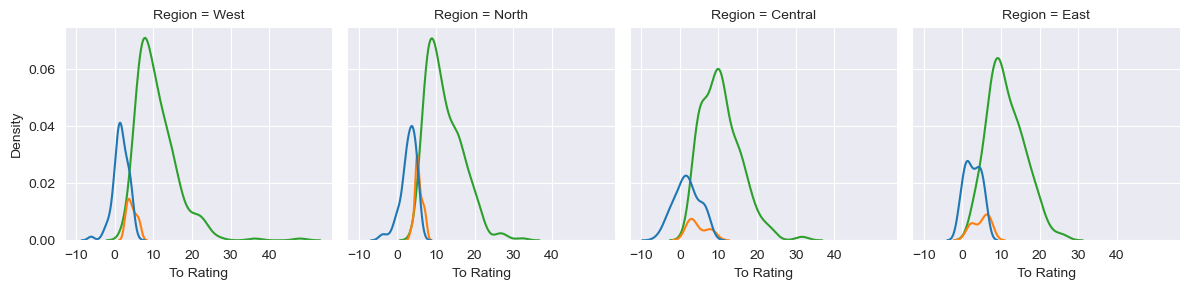

In [34]:
g = sns.FacetGrid(scores, col='Region')
g.map_dataframe(sns.kdeplot, x='To Rating', hue='Outcome')
g.set(xticks=np.arange(-10,41,10));

# Predictive Modeling - Using To Par
## Need to run again using To Rating...

In [35]:
# Make 'Outcome' binary response variable
scores['Qualified'] = (scores['Outcome'] == 'Qualified').astype(int)
scores

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Rating,Slope,Qualifying Rate (%),Weather Risk,Region,To Rating,Qualified
0,1,-1,71,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,-0.6,1
1,2,0,72,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,0.4,1
2,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4,1
3,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4,1
4,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,CUT,14,86,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,14.2,0
1410,CUT,15,87,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,15.2,0
1411,CUT,15,87,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,15.2,0
1412,CUT,18,90,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,18.2,0


In [36]:
# Remove: Pos., To Par, Total, Event ID, Qualifier Course, Date, Slope
y, X = patsy.dmatrices('Qualified ~ Q("To Par") + C(Q("Weather Risk"), Sum) + C(Region, Sum)',data=scores, return_type='dataframe')

In [37]:
X

,Intercept,"C(Q(""Weather Risk""), Sum)[S.High]","C(Q(""Weather Risk""), Sum)[S.Low]","C(Region, Sum)[S.Central]","C(Region, Sum)[S.East]","C(Region, Sum)[S.North]","Q(""To Par"")"
0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0
...,...,...,...,...,...,...,...
1409,1.0,-1.0,-1.0,0.0,0.0,1.0,14.0
1410,1.0,-1.0,-1.0,0.0,0.0,1.0,15.0
1411,1.0,-1.0,-1.0,0.0,0.0,1.0,15.0
1412,1.0,-1.0,-1.0,0.0,0.0,1.0,18.0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)

In [39]:
log_model = sm.Logit(y_train, X_train).fit()
predictions = log_model.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.123447
         Iterations 11


In [40]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  989
Model:                          Logit   Df Residuals:                      982
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                  0.7446
Time:                        10:51:12   Log-Likelihood:                -122.09
converged:                       True   LL-Null:                       -478.09
Covariance Type:            nonrobust   LLR p-value:                1.563e-150
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.3228      0.873      9.533      0.000       6.612      10.034
C(Q("Weather Risk"), Sum)[S.High]     2.5819      0.451      5.721      0.000       1.697       3.466
C(Q("Weather Risk"), Sum)[S.Low]     -2.2794      0.338     -6.742      0.000      -2.942      -1.617
C(Region, Sum)[S.Central]             0.6085      0.302      2.014      0.044       0.016       1.201
C(Region, Sum)[S.East]                0.0301      0.351      0.086      0.932      -0.658       0.718
C(Region, Sum)[S.North]               0.3903      0.285      1.369      0.171      -0.168       0.949
Q("To Par")                          -1.5869      0.157    -10.090      0.000      -1.895      -1.279
=====================================================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [41]:
# This means that the coefficient for Weather Risk Medium is the negative sum of the other two ~-.30
# Means that the log(odds) of qualifying reduce by -0.30 if the weather risk is medium
log_model.params

Intercept                            8.322818
C(Q("Weather Risk"), Sum)[S.High]    2.581922
C(Q("Weather Risk"), Sum)[S.Low]    -2.279396
C(Region, Sum)[S.Central]            0.608544
C(Region, Sum)[S.East]               0.030062
C(Region, Sum)[S.North]              0.390290
Q("To Par")                         -1.586926
dtype: float64

In [42]:
print(f'Medium Risk: {-(log_model.params.iloc[1] + log_model.params.iloc[2])}')

Medium Risk: -0.3025252946346244


In [43]:
# Similarly, the West region has a coefficient of -1.0. Meaning the log odds of qualifying reduce by -1.0 if you're in the West Region
print(f'West Region: {-(log_model.params.iloc[3] + log_model.params.iloc[4] + log_model.params.iloc[5])}')

West Region: -1.028895932636559


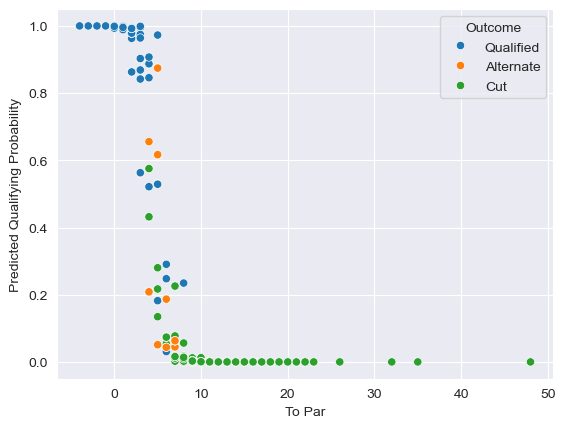

In [44]:
ax = sns.scatterplot(x=scores['To Par'], y=predictions, hue=scores['Outcome'])
ax.set_ylabel('Predicted Qualifying Probability');

In [45]:
labels=(predictions>.5).astype(int)

In [46]:
y_test

,Qualified
1208,0.0
1230,0.0
547,0.0
541,0.0
878,0.0
...,...
1085,0.0
1067,0.0
776,1.0
947,1.0


In [47]:
(labels == y_test['Qualified']).mean()

np.float64(0.9388235294117647)

In [82]:
df = scores.copy()
df['Qualified'] = df['Outcome'] == 'Qualified'
df[df['To Par'] < 3]['Qualified'].mean()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [49]:
df['to_par_bin'] = pd.cut(df['To Par'], bins=[-10, -5, 0, 5, 10, 50])
pd.crosstab(df['to_par_bin'], df['Outcome'])

Outcome,Alternate,Cut,Qualified
to_par_bin,,,
"(-10, -5]",0,0,1
"(-5, 0]",0,0,41
"(0, 5]",38,46,210
"(5, 10]",39,458,24
"(10, 50]",0,557,0


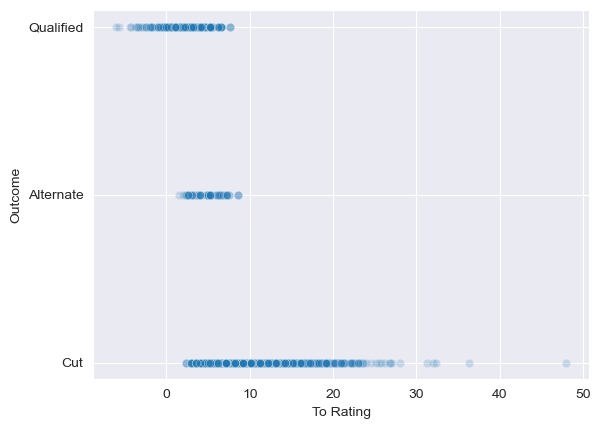

In [50]:
sns.scatterplot(x='To Rating', y='Outcome', data=df, alpha=0.2);

<h2>Quasi-separation found. The real sweet spot where there is some overlap is between 0 to 10. Based on historical data, someone with a score of E or better has always qualified, meanwhile someone with a score above +10 has never qualified. Because of this clean separation, the logistic model breaks because it assumes some overlap and a smooth probability curve, whereas this is more of a step curve.</h2>
We will re-run our logit model only on data where score relative to par was between +1 and +10.

In [51]:
mid_scores = scores[scores['To Par'].between(1,10)]
mid_scores.head(10)

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Rating,Slope,Qualifying Rate (%),Weather Risk,Region,To Rating,Qualified
2,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4,1
3,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4,1
4,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4,1
5,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4,1
6,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4,1
7,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4,1
8,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4,1
9,10,5,77,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,5.4,1
10,CUT,5,77,Alternate,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,5.4,0
11,CUT,6,78,Cut,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,6.4,0


In [52]:
mid_scores['to_par_bin'] = pd.cut(mid_scores.loc[:,'To Par'], bins=[-10, -5, 0, 5, 10, 50])
pd.crosstab(mid_scores['to_par_bin'], mid_scores['Qualified'])

# Nice overlap here.

/var/folders/pv/5jmsdzls0d177bpn85prxjr40000gn/T/ipykernel_2827/2792553239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_scores['to_par_bin'] = pd.cut(mid_scores.loc[:,'To Par'], bins=[-10, -5, 0, 5, 10, 50])


Qualified,0,1
to_par_bin,,
"(0, 5]",84,210
"(5, 10]",497,24


In [53]:
y, X = patsy.dmatrices('Qualified ~ Q("To Par") + C(Q("Weather Risk"), Sum) + C(Region, Sum)', data=mid_scores, return_type='dataframe')

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)

In [55]:
mid_log_model = sm.Logit(y_train, X_train).fit()
predictions = mid_log_model.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.218438
         Iterations 9


In [56]:
mid_log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  570
Model:                          Logit   Df Residuals:                      563
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                  0.6299
Time:                        10:51:13   Log-Likelihood:                -124.51
converged:                       True   LL-Null:                       -336.46
Covariance Type:            nonrobust   LLR p-value:                 2.024e-88
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.1116      0.834      9.725      0.000       6.477       9.746
C(Q("Weather Risk"), Sum)[S.High]     2.5031      0.452      5.535      0.000       1.617       3.390
C(Q("Weather Risk"), Sum)[S.Low]     -1.8258      0.312     -5.861      0.000      -2.436      -1.215
C(Region, Sum)[S.Central]             0.5259      0.302      1.740      0.082      -0.066       1.118
C(Region, Sum)[S.East]                0.0705      0.320      0.220      0.826      -0.557       0.698
C(Region, Sum)[S.North]               0.4968      0.279      1.780      0.075      -0.050       1.044
Q("To Par")                          -1.5227      0.147    -10.373      0.000      -1.810      -1.235
=====================================================================================================
"""

In [57]:
labels = predictions > 0.5
(labels == y_test['Qualified']).mean()

np.float64(0.8979591836734694)

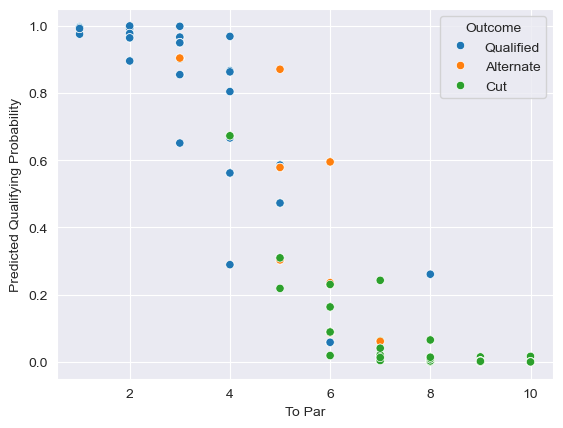

In [58]:
ax = sns.scatterplot(x=scores['To Par'], y=predictions, hue=scores['Outcome'])
ax.set_ylabel('Predicted Qualifying Probability');

Confusion Matrix as NumPy array:
[[158  11]
 [ 14  62]]


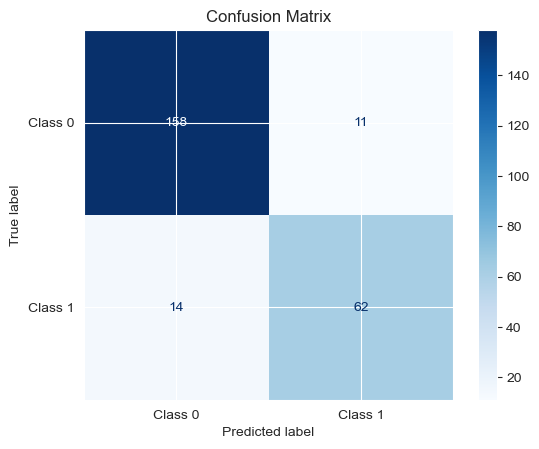

In [59]:
cm = confusion_matrix(y_test['Qualified'], labels)
print("Confusion Matrix as NumPy array:")
print(cm)

# 3. Visualize the confusion matrix with labels using ConfusionMatrixDisplay
# Rows typically represent actual values, columns represent predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues) # Use a colormap for better visualization
plt.title("Confusion Matrix")
plt.show()

In [60]:
# With without region term
y, X = patsy.dmatrices('Qualified ~ Q("To Par") + C(Q("Weather Risk"), Sum)', data=mid_scores, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)
mid_nonregional_log_model = sm.Logit(y_train, X_train).fit()
predictions = mid_nonregional_log_model.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.232691
         Iterations 8


In [61]:
mid_nonregional_log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  570
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            3
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                  0.6058
Time:                        10:51:13   Log-Likelihood:                -132.63
converged:                       True   LL-Null:                       -336.46
Covariance Type:            nonrobust   LLR p-value:                 4.865e-88
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.4248      0.753      9.855      0.000       5.948       8.902
C(Q("Weather Risk"), Sum)[S.High]     2.1478      0.403      5.323      0.000       1.357       2.939
C(Q("Weather Risk"), Sum)[S.Low]     -1.4921      0.280     -5.328      0.000      -2.041      -0.943
Q("To Par")                          -1.4111      0.132    -10.689      0.000      -1.670      -1.152
=====================================================================================================
"""

In [62]:
labels = predictions > 0.5
(labels == y_test['Qualified']).mean()

# Hardly lost any accuracy after removing region.

np.float64(0.8734693877551021)

Confusion Matrix as NumPy array:
[[158  11]
 [ 20  56]]


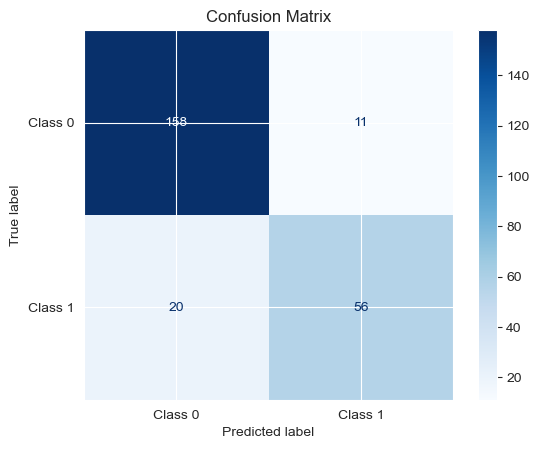

In [63]:
cm = confusion_matrix(y_test['Qualified'], labels)
print("Confusion Matrix as NumPy array:")
print(cm)

# 3. Visualize the confusion matrix with labels using ConfusionMatrixDisplay
# Rows typically represent actual values, columns represent predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues) # Use a colormap for better visualization
plt.title("Confusion Matrix")
plt.show()

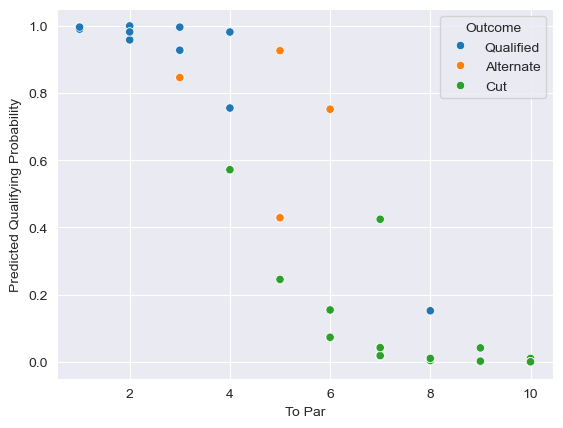

In [64]:
ax = sns.scatterplot(x=scores['To Par'], y=predictions, hue=scores['Outcome'])
ax.set_ylabel('Predicted Qualifying Probability');

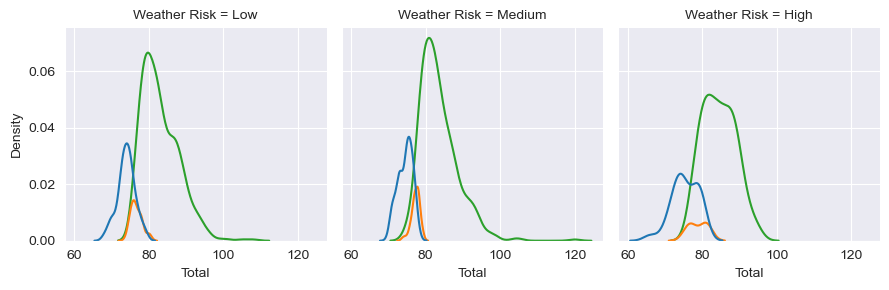

In [65]:
### Looks like weather widens the score ranges. High is tricky since only two events in sample.
g = sns.FacetGrid(scores, col='Weather Risk', col_order=['Low', 'Medium', 'High'])
g.map_dataframe(sns.kdeplot, x='Total', hue='Outcome');

In [66]:
# With interaction term
y, X = patsy.dmatrices('Qualified ~ Q("To Par") + C(Q("Weather Risk"), Sum) + C(Q("Weather Risk"), Sum):Q("To Par")', data=mid_scores, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)
interaction_mid_log_model = sm.Logit(y_train, X_train).fit()
predictions = interaction_mid_log_model.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.230492
         Iterations 9


In [67]:
interaction_mid_log_model.summary()

# Interactions not good. Insignificant and muddy up other key variables (Weather Risk).

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  570
Model:                          Logit   Df Residuals:                      564
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                  0.6095
Time:                        10:51:15   Log-Likelihood:                -131.38
converged:                       True   LL-Null:                       -336.46
Covariance Type:            nonrobust   LLR p-value:                 1.914e-86
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         7.3527      1.104      6.661      0.000       5.189       9.516
C(Q("Weather Risk"), Sum)[S.High]                 1.1503      2.021      0.569      0.569      -2.810       5.110
C(Q("Weather Risk"), Sum)[S.Low]                 -2.0936      1.186     -1.765      0.078      -4.419       0.231
Q("To Par")                                      -1.4098      0.171     -8.231      0.000      -1.745      -1.074
C(Q("Weather Risk"), Sum)[S.High]:Q("To Par")     0.1510      0.293      0.516      0.606      -0.423       0.725
C(Q("Weather Risk"), Sum)[S.Low]:Q("To Par")      0.1514      0.195      0.775      0.438      -0.232       0.534
=================================================================================================================
"""

In [68]:
labels = predictions > 0.5
(labels == y_test['Qualified']).mean()

np.float64(0.8734693877551021)

Confusion Matrix as NumPy array:
[[158  11]
 [ 20  56]]


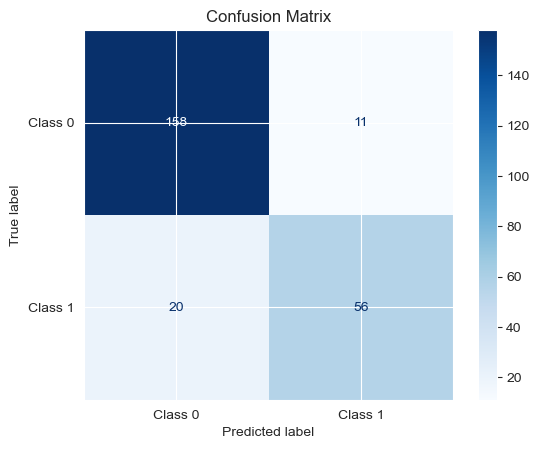

In [69]:
cm = confusion_matrix(y_test['Qualified'], labels)
print("Confusion Matrix as NumPy array:")
print(cm)

# 3. Visualize the confusion matrix with labels using ConfusionMatrixDisplay
# Rows typically represent actual values, columns represent predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues) # Use a colormap for better visualization
plt.title("Confusion Matrix")
plt.show()

# Holding All Else Constant, What Is the Probability of Qualifying Based on To Par?

In [70]:
medium_risk_coef = -(mid_nonregional_log_model.params.iloc[1] + mid_nonregional_log_model.params.iloc[2])
new_entry = pd.Series([medium_risk_coef], index=['C(Q("Weather Risk"), Sum)[S.Medium]'])

# Concatenate the original Series and the new entry
mid_nonregional_log_model.params = pd.concat([mid_nonregional_log_model.params, new_entry])
mid_nonregional_log_model.params

Intercept                              7.424828
C(Q("Weather Risk"), Sum)[S.High]      2.147819
C(Q("Weather Risk"), Sum)[S.Low]      -1.492070
Q("To Par")                           -1.411144
C(Q("Weather Risk"), Sum)[S.Medium]   -0.655749
dtype: float64

In [71]:
custom_order = ['Intercept', 'C(Q("Weather Risk"), Sum)[S.Low]', 'C(Q("Weather Risk"), Sum)[S.Medium]', 'C(Q("Weather Risk"), Sum)[S.High]', 'Q("To Par")']
coefs = pd.DataFrame(mid_nonregional_log_model.params).reindex(custom_order)
coefs.columns = ['Coefficient']
coefs

,Coefficient
Intercept,7.424828
"C(Q(""Weather Risk""), Sum)[S.Low]",-1.492070
"C(Q(""Weather Risk""), Sum)[S.Medium]",-0.655749
"C(Q(""Weather Risk""), Sum)[S.High]",2.147819
"Q(""To Par"")",-1.411144


This means, holding all else equal, the log odds that someone would qualify would decrease by -1.49 if the weather at their qualifier was classified as "low risk". To see the effect on the odds, you would exponentiate the coefficients.

In [72]:
coefs['Exponentiated'] = np.exp(coefs['Coefficient'])
coefs

,Coefficient,Exponentiated
Intercept,7.424828,1677.110653
"C(Q(""Weather Risk""), Sum)[S.Low]",-1.492070,0.224907
"C(Q(""Weather Risk""), Sum)[S.Medium]",-0.655749,0.519053
"C(Q(""Weather Risk""), Sum)[S.High]",2.147819,8.566155
"Q(""To Par"")",-1.411144,0.243864


This says that playing in a low weather risk event would change the odds of you qualifying with the same score are multiplied by 22%, meaning they have reduced by 78%. Meanwhile, shooting the same score in a high-risk weather scenario, your odds would multiply by 8.6x.

In [73]:
# p(X) = e^(ß_0 + ß1X1 + ... + ßnXn) / [1 + e^(ß_0 + ß1X1 + ... + ßnXn)]

## Low Weather Risk, Shooting Even
scores = np.arange(1,11)
lowrisk_probs = []
medrisk_probs = []
highrisk_probs = []

for score in scores:
    q_prob = np.exp(7.424828 + (-1.492070) + (-1.411144*score)) / (1+np.exp(7.424828 + (-1.492070) + (-1.411144*score)))
    lowrisk_probs.append(q_prob)
    print(f'Probability of qualifying in a low-risk environment with a score of +{score}: {q_prob:.2f}')

for score in scores:
    q_prob = np.exp(7.424828 + (-0.655749) + (-1.411144*score)) / (1+np.exp(7.424828 + (-0.655749) + (-1.411144*score)))
    medrisk_probs.append(q_prob)
    print(f'Probability of qualifying in a medium-risk environment with a score of +{score}: {q_prob:.2f}')    

for score in scores:
    q_prob = np.exp(7.424828 + (2.147819) + (-1.411144*score)) / (1+np.exp(7.424828 + (2.147819) + (-1.411144*score)))
    highrisk_probs.append(q_prob)
    print(f'Probability of qualifying in a high-risk environment with a score of +{score}: {q_prob:.2f}')    

Probability of qualifying in a low-risk environment with a score of +1: 0.99
Probability of qualifying in a low-risk environment with a score of +2: 0.96
Probability of qualifying in a low-risk environment with a score of +3: 0.85
Probability of qualifying in a low-risk environment with a score of +4: 0.57
Probability of qualifying in a low-risk environment with a score of +5: 0.25
Probability of qualifying in a low-risk environment with a score of +6: 0.07
Probability of qualifying in a low-risk environment with a score of +7: 0.02
Probability of qualifying in a low-risk environment with a score of +8: 0.00
Probability of qualifying in a low-risk environment with a score of +9: 0.00
Probability of qualifying in a low-risk environment with a score of +10: 0.00
Probability of qualifying in a medium-risk environment with a score of +1: 1.00
Probability of qualifying in a medium-risk environment with a score of +2: 0.98
Probability of qualifying in a medium-risk environment with a score o

In [74]:
df = {'Low': lowrisk_probs, 'Medium': medrisk_probs, 'High': highrisk_probs}
df = pd.DataFrame(df)
df['x'] = [f'+{i+1}' for i in df.index]
df

,Low,Medium,High,x
0,0.989245,0.995311,0.999715,+1
1,0.957323,0.981049,0.998831,+2
2,0.845447,0.926603,0.995223,+3
3,0.571551,0.754823,0.980698,+4
4,0.245462,0.428826,0.925320,+5
5,0.073502,0.154755,0.751342,+6
6,0.018979,0.042740,0.424247,+7
7,0.004696,0.010771,0.152322,+8
8,0.001149,0.002648,0.041981,+9
9,0.000280,0.000647,0.010573,+10


In [75]:
# reshape for seaborn
df_long = df.melt(id_vars="x", var_name="Weather Risk", value_name="Probability")
df_long

,x,Weather Risk,Probability
0,+1,Low,0.989245
1,+2,Low,0.957323
2,+3,Low,0.845447
3,+4,Low,0.571551
4,+5,Low,0.245462
5,+6,Low,0.073502
6,+7,Low,0.018979
7,+8,Low,0.004696
8,+9,Low,0.001149
9,+10,Low,0.000280


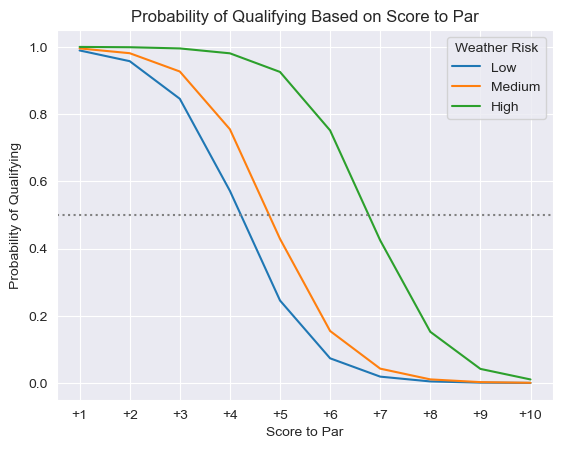

In [76]:
ax = sns.lineplot(data=df_long, x="x", y="Probability", hue="Weather Risk")
ax.set_xticks(np.arange(0,10))

# Set the corresponding custom labels
ax.set_xlabel('Score to Par')
ax.set_ylabel('Probability of Qualifying')
ax.set_title('Probability of Qualifying Based on Score to Par')
ax.axhline(0.5, c='grey', ls=':');

# Other analyses
- Difficulty of courses by Region
- Incorporate 'Alternate' as an outcome

In [77]:
# To Rating has similar performance and output, but most folks would probably use par as a benchmark rather than the course rating.
y, X = patsy.dmatrices('Qualified ~ Q("To Rating") + C(Q("Weather Risk"), Sum)', data=mid_scores, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)
to_rating_log_model = sm.Logit(y_train, X_train).fit()
predictions = to_rating_log_model.predict(X_test)
to_rating_log_model.summary()

Optimization terminated successfully.
         Current function value: 0.286696
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  570
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            3
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                  0.5143
Time:                        10:51:15   Log-Likelihood:                -163.42
converged:                       True   LL-Null:                       -336.46
Covariance Type:            nonrobust   LLR p-value:                 1.049e-74
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.8119      0.508      9.476      0.000       3.817       5.807
C(Q("Weather Risk"), Sum)[S.High]     1.5065      0.347      4.346      0.000       0.827       2.186
C(Q("Weather Risk"), Sum)[S.Low]     -1.3063      0.248     -5.269      0.000      -1.792      -0.820
Q("To Rating")                       -1.0672      0.096    -11.067      0.000      -1.256      -0.878
=====================================================================================================
"""

In [78]:
# p(X) = e^(ß_0 + ß1X1 + ... + ßnXn) / [1 + e^(ß_0 + ß1X1 + ... + ßnXn)]

## Low Weather Risk, Shooting Even
scores = np.arange(1,11)
lowrisk_probs = []
medrisk_probs = []
highrisk_probs = []

for score in scores:
    q_prob = np.exp(4.8119 + (-1.3063) + (-1.0672*score)) / (1+np.exp(4.8119 + (-1.3063) + (-1.0672*score)))
    lowrisk_probs.append(q_prob)
    print(f'Probability of qualifying in a low-risk environment with a score of +{score} vs. Course Rating: {q_prob:.2f}')

for score in scores:
    q_prob = np.exp(4.8119 + (-0.20019) + (-1.0672*score)) / (1+np.exp(4.8119 + (-0.200199) + (-1.0672*score)))
    medrisk_probs.append(q_prob)
    print(f'Probability of qualifying in a medium-risk environment with a score of +{score} vs. Course Rating: {q_prob:.2f}')    

for score in scores:
    q_prob = np.exp(4.8119 + (1.5065) + (-1.0672*score)) / (1+np.exp(4.8119 + (1.5065) + (-1.0672*score)))
    highrisk_probs.append(q_prob)
    print(f'Probability of qualifying in a high-risk environment with a score of +{score} vs. Course Rating: {q_prob:.2f}')    

Probability of qualifying in a low-risk environment with a score of +1 vs. Course Rating: 0.92
Probability of qualifying in a low-risk environment with a score of +2 vs. Course Rating: 0.80
Probability of qualifying in a low-risk environment with a score of +3 vs. Course Rating: 0.58
Probability of qualifying in a low-risk environment with a score of +4 vs. Course Rating: 0.32
Probability of qualifying in a low-risk environment with a score of +5 vs. Course Rating: 0.14
Probability of qualifying in a low-risk environment with a score of +6 vs. Course Rating: 0.05
Probability of qualifying in a low-risk environment with a score of +7 vs. Course Rating: 0.02
Probability of qualifying in a low-risk environment with a score of +8 vs. Course Rating: 0.01
Probability of qualifying in a low-risk environment with a score of +9 vs. Course Rating: 0.00
Probability of qualifying in a low-risk environment with a score of +10 vs. Course Rating: 0.00
Probability of qualifying in a medium-risk enviro

In [79]:
df = {'Low': lowrisk_probs, 'Medium': medrisk_probs, 'High': highrisk_probs}
df = pd.DataFrame(df)
df['x'] = [f'+{i+1}' for i in df.index]
df

,Low,Medium,High,x
0,0.919709,0.971937,0.994786,+1
1,0.797574,0.922543,0.984991,+2
2,0.575420,0.803789,0.957580,+3
3,0.317952,0.584900,0.885907,+4
4,0.138191,0.326450,0.727584,+5
5,0.052272,0.142890,0.478813,+6
6,0.018619,0.054234,0.240124,+7
7,0.006483,0.019343,0.098040,+8
8,0.002240,0.006739,0.036041,+9
9,0.000772,0.002328,0.012697,+10


In [80]:
df_long = df.melt(id_vars="x", var_name="Weather Risk", value_name="Probability")
df_long

,x,Weather Risk,Probability
0,+1,Low,0.919709
1,+2,Low,0.797574
2,+3,Low,0.575420
3,+4,Low,0.317952
4,+5,Low,0.138191
5,+6,Low,0.052272
6,+7,Low,0.018619
7,+8,Low,0.006483
8,+9,Low,0.002240
9,+10,Low,0.000772


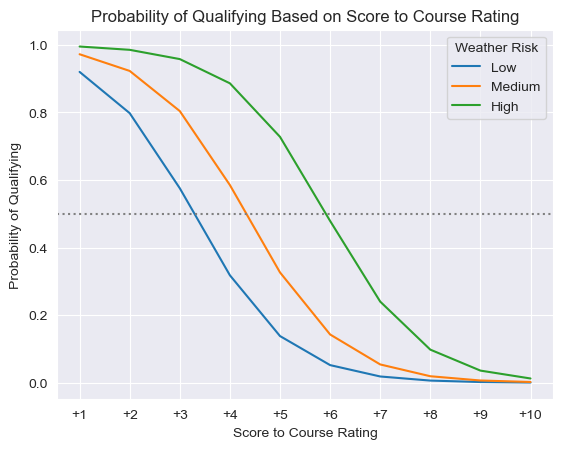

In [81]:
ax = sns.lineplot(data=df_long, x="x", y="Probability", hue="Weather Risk")
ax.set_xticks(np.arange(0,10))

# Set the corresponding custom labels
ax.set_xlabel('Score to Course Rating')
ax.set_ylabel('Probability of Qualifying')
ax.set_title('Probability of Qualifying Based on Score to Course Rating')
ax.axhline(0.5, c='grey', ls=':');